In [ ]:
# ==============================
# 1. ربط Google Drive
# ==============================
from google.colab import drive
drive.mount('/content/drive')

# ==============================
# 2. تحميل جميع المكونات المحفوظة
# ==============================
import pandas as pd
import joblib
import xgboost as xgb
import tensorflow as tf
import numpy as np

SAVE_PATH = "/content/drive/MyDrive/TEP_Data"

# تحميل البيانات الهجينة
train_df = pd.read_csv(f"{SAVE_PATH}/hybrid_train.csv")
test_df = pd.read_csv(f"{SAVE_PATH}/test_hybrid.csv")

# تحميل النماذج والمسطّرات
scaler = joblib.load(f"{SAVE_PATH}/scaler.pkl")
xgb_model = xgb.XGBClassifier()
xgb_model.load_model(f"{SAVE_PATH}/xgboost_hybrid_v2.json")
label_classes = np.load(f"{SAVE_PATH}/label_encoder_v2.npy")
autoencoder = tf.keras.models.load_model(f"{SAVE_PATH}/digital_twin_ae.keras")

# تحديد أعمدة المستشعرات
SENSOR_COLUMNS = [col for col in train_df.columns
                  if col not in ['faultNumber', 'simulationRun', 'sample']]

print("🟢 جاهز تمامًا للاستمرار من حيث توقفت!")
print(f"- تدريب: {len(train_df)} عينة | اختبار: {len(test_df)} عينة")
print(f"- الفئات: {len(label_classes)} (F0 إلى F23)")

Mounted at /content/drive
🟢 جاهز تمامًا للاستمرار من حيث توقفت!
- تدريب: 333333 عينة | اختبار: 66667 عينة
- الفئات: 24 (F0 إلى F23)


In [ ]:
# 1. ربط Colab بـ Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 2. تحديد مسار المجلد الصحيح (Digital-Twin)
DATA_PATH = "/content/drive/MyDrive/Digital-Twin"

# 3. استيراد المكتبات المطلوبة
import pandas as pd
import numpy as np
import os

# 4. أسماء الملفات
files = {
    'fault_free_train': 'TEP_FaultFree_Training.csv',
    'fault_free_test': 'TEP_FaultFree_Testing.csv',
    'faulty_train': 'TEP_Faulty_Training.csv',
    'faulty_test': 'TEP_Faulty_Testing.csv'
}

# 5. قراءة الملفات مع الحفاظ على الذاكرة
data = {}
for key, filename in files.items():
    file_path = os.path.join(DATA_PATH, filename)
    if os.path.exists(file_path):
        try:
            # إذا كان الملف هو الكبير (faulty_test) نقرأه بعينات أو chunks
            if key == 'faulty_test':
                print(f"⚠️ الملف كبير: {filename} – سيتم قراءته على دفعات لتفادي استهلاك الذاكرة")

                # مثال: قراءة أول 100 ألف صف فقط
                data[key] = pd.read_csv(file_path, nrows=100000)

                # أو يمكنك استخدام chunksize لمعالجة تدريجية
                # chunks = pd.read_csv(file_path, chunksize=50000)
                # for i, chunk in enumerate(chunks):
                #     print(f"✅ Chunk {i} – الشكل: {chunk.shape}")
                #     # هنا يمكنك معالجة كل جزء على حدة
                #     if i == 1: break  # مثال: نقرأ أول جزئين فقط

            else:
                # الملفات الأخرى تُقرأ مباشرة
                data[key] = pd.read_csv(file_path)

            print(f"✅ تم تحميل '{filename}' – الأبعاد: {data[key].shape}")
        except Exception as e:
            print(f"❌ خطأ أثناء قراءة {filename}: {e}")
    else:
        print(f"❌ الملف '{filename}' غير موجود في المسار: {file_path}")


Mounted at /content/drive
✅ تم تحميل 'TEP_FaultFree_Training.csv' – الأبعاد: (250000, 55)
✅ تم تحميل 'TEP_FaultFree_Testing.csv' – الأبعاد: (480000, 55)
✅ تم تحميل 'TEP_Faulty_Training.csv' – الأبعاد: (5000000, 55)
⚠️ الملف كبير: TEP_Faulty_Testing.csv – سيتم قراءته على دفعات لتفادي استهلاك الذاكرة
✅ تم تحميل 'TEP_Faulty_Testing.csv' – الأبعاد: (100000, 55)


In [ ]:
# عرض معلومات عامة عن كل ملف
for key, df in data.items():
    print(f"\n=== {key.upper()} ===")
    print(f"الشكل (rows, cols): {df.shape}")
    print(f"الأعمدة الأولى: {list(df.columns[:5])}")
    print(f"الأعمدة الأخيرة: {list(df.columns[-5:])}")

    # التحقق من وجود عمود 'fault_number' أو ما يشبهه
    fault_cols = [col for col in df.columns if 'fault' in col.lower()]
    if fault_cols:
        print(f"✅ عمود/أعمدة العطل: {fault_cols}")
        print("قيم العطل الفريدة:", sorted(df[fault_cols[0]].unique()))
    else:
        print("⚠️ لم يُعثر على عمود يشير إلى نوع العطل!")

    # التحقق من القيم المفقودة
    missing = df.isnull().sum().sum()
    print(f"القيم المفقودة (NaN): {missing}")

    # أنواع البيانات
    print("أنواع البيانات (dtypes):")
    print(df.dtypes.value_counts())


=== FAULT_FREE_TRAIN ===
الشكل (rows, cols): (250000, 55)
الأعمدة الأولى: ['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2']
الأعمدة الأخيرة: ['xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']
✅ عمود/أعمدة العطل: ['faultNumber']
قيم العطل الفريدة: [np.int64(0)]
القيم المفقودة (NaN): 0
أنواع البيانات (dtypes):
float64    52
int64       3
Name: count, dtype: int64

=== FAULT_FREE_TEST ===
الشكل (rows, cols): (480000, 55)
الأعمدة الأولى: ['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2']
الأعمدة الأخيرة: ['xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']
✅ عمود/أعمدة العطل: ['faultNumber']
قيم العطل الفريدة: [np.int64(0)]
القيم المفقودة (NaN): 0
أنواع البيانات (dtypes):
float64    52
int64       3
Name: count, dtype: int64

=== FAULTY_TRAIN ===
الشكل (rows, cols): (5000000, 55)
الأعمدة الأولى: ['faultNumber', 'simulationRun', 'sample', 'xmeas_1', 'xmeas_2']
الأعمدة الأخيرة: ['xmv_7', 'xmv_8', 'xmv_9', 'xmv_10', 'xmv_11']
✅ عمود/أعمدة العطل: ['faultNumber']
قيم العطل

In [ ]:
# التحقق من تطابق أسماء الأعمدة
cols_train = set(data['fault_free_train'].columns)
cols_test = set(data['fault_free_test'].columns)
cols_faulty_train = set(data['faulty_train'].columns)
cols_faulty_test = set(data['faulty_test'].columns)

print("هل أعمدة التدريب الخالي من الأعطال = أعمدة الاختبار الخالي؟", cols_train == cols_test)
print("هل أعمدة التدريب العاطل = أعمدة الاختبار العاطل؟", cols_faulty_train == cols_faulty_test)

# عادةً: ملفات "faulty" تحتوي على عمود إضافي مثل 'fault_number'
extra_cols = cols_faulty_train - cols_train
print("الأعمدة الإضافية في ملفات 'faulty' (من المتوقع 'fault_number'):", extra_cols)

هل أعمدة التدريب الخالي من الأعطال = أعمدة الاختبار الخالي؟ True
هل أعمدة التدريب العاطل = أعمدة الاختبار العاطل؟ True
الأعمدة الإضافية في ملفات 'faulty' (من المتوقع 'fault_number'): set()


In [ ]:
# افتراض أن 'fault_free_train' لا يحتوي على عمود العطل
base_cols = data['fault_free_train'].columns.tolist()

# التعريف الصحيح لأعمدة أجهزة الاستشعار والتحكم
SENSOR_COLUMNS = [col for col in data['fault_free_train'].columns
                  if col not in ['faultNumber', 'simulationRun', 'sample']]
print(f"✅ عدد المتغيرات (xmeas + xmv): {len(SENSOR_COLUMNS)}")  # يجب أن يطبع 52

✅ عدد المتغيرات (xmeas + xmv): 52


In [ ]:
# حفظ قائمة أعمدة أجهزة الاستشعار كمرجع
FAULT_COLUMN = list(extra_cols)[0] if extra_cols else None

print("\n📌 ملخص:")
print(f"- أعمدة أجهزة الاستشعار: {len(SENSOR_COLUMNS)}")
print(f"- عمود العطل: {FAULT_COLUMN}")
print(f"- شكل بيانات التدريب العاطل: {data['fault_free_train'].shape}")
print(f"- شكل بيانات التدريب مع العطل: {data['faulty_train'].shape}")


📌 ملخص:
- أعمدة أجهزة الاستشعار: 52
- عمود العطل: None
- شكل بيانات التدريب العاطل: (250000, 55)
- شكل بيانات التدريب مع العطل: (5000000, 55)


توزيع الأعطال في بيانات التدريب:
faultNumber
0     250000
1     250000
2     250000
3     250000
4     250000
5     250000
6     250000
7     250000
8     250000
9     250000
10    250000
11    250000
12    250000
13    250000
14    250000
15    250000
16    250000
17    250000
18    250000
19    250000
20    250000
Name: count, dtype: int64


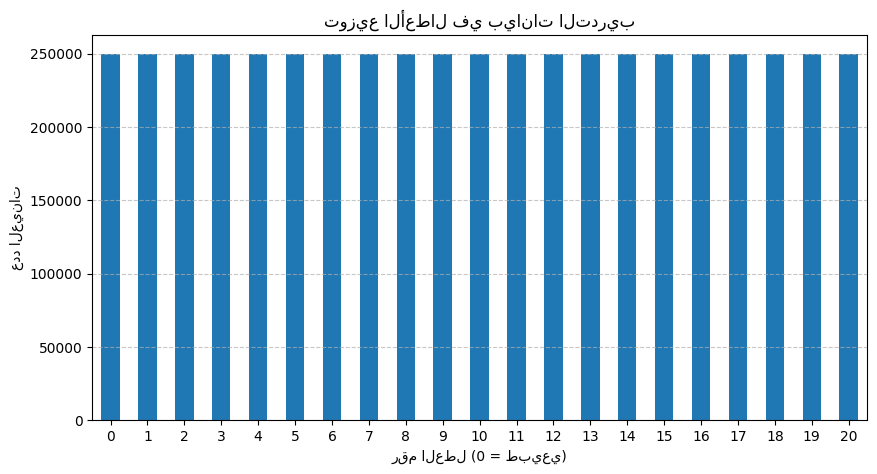

الأعطال النادرة (أقل من 100000 عينة): []


In [ ]:
train_df = pd.concat([data['fault_free_train'], data['faulty_train']], ignore_index=True)
fault_counts = train_df['faultNumber'].value_counts().sort_index()
print("توزيع الأعطال في بيانات التدريب:")
print(fault_counts)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
fault_counts.plot(kind='bar')
plt.title('توزيع الأعطال في بيانات التدريب')
plt.xlabel('رقم العطل (0 = طبيعي)')
plt.ylabel('عدد العينات')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
THRESHOLD = 100_000
rare_faults = fault_counts[fault_counts < THRESHOLD].index.tolist()
print(f"الأعطال النادرة (أقل من {THRESHOLD} عينة): {rare_faults}")

In [ ]:
!pip install tensorflow

TensorFlow version: 2.19.0
GPU Available: []
عدد عينات الحالة الطبيعية: 250000
عدد المتغيرات (xmeas + xmv): 52


Model: "Digital_Twin_AE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_1 (Dense)             │ (None, 32)             │         1,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ enc_dense_2 (Dense)             │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_1 (Dense)             │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dec_dense_2 (Dense)             │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 52)             │         1,716 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,764 (18.61 KB)

 Trainable params: 4,764 (18.61 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.7591 - val_loss: 0.5513
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5457 - val_loss: 0.5354
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5324 - val_loss: 0.5265
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5254 - val_loss: 0.5248
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5245 - val_loss: 0.5242
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5239 - val_loss: 0.5240
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5236 - val_loss: 0.5244
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5237 - val_loss: 0.5242
Epoch 9/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5238 - val_loss: 0.5240
Epoch 10/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.5237 - val_loss: 0.5240
Epoch 11/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.5240 - val_loss: 0.5239
Epoch 12/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

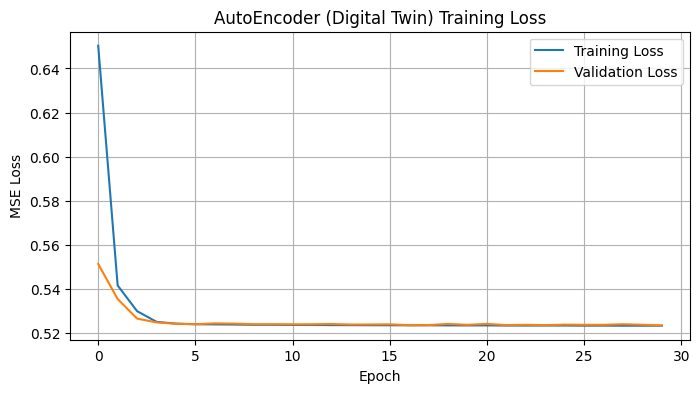

✅ تم الحفظ بنجاح في: /content/drive/MyDrive/TEP_Data
📁 الملفات المحفوظة: ['train_full.csv', 'synthetic_faults.csv', 'hybrid_train.csv', 'test_full.csv', 'scaler.pkl', 'digital_twin_ae.keras', 'xgboost_hybrid.json', 'label_encoder_classes.npy']
✅ تم حفظ النموذج الرقمي (Digital Twin) والمسطرة بنجاح!


In [ ]:
# 1. تثبيت TensorFlow (إذا لزم الأمر)
try:
    import tensorflow as tf
except ImportError:
    !pip install tensorflow
    import tensorflow as tf

# 2. المكتبات الأخرى
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os  # Moved here
import joblib # Moved here

# 3. التأكد من أن GPU متاح (اختياري لكن مفيد)
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# 4. استخراج بيانات الحالة الطبيعية فقط
normal_data = train_df[train_df['faultNumber'] == 0].copy()
print(f"عدد عينات الحالة الطبيعية: {len(normal_data)}")

# 5. تحديد أعمدة أجهزة الاستشعار (52 عمودًا)
SENSOR_COLUMNS = [col for col in train_df.columns
                  if col not in ['faultNumber', 'simulationRun', 'sample']]
print(f"عدد المتغيرات (xmeas + xmv): {len(SENSOR_COLUMNS)}")

X_normal = normal_data[SENSOR_COLUMNS].values

# 6. توحيد البيانات
scaler = StandardScaler()
X_normal_scaled = scaler.fit_transform(X_normal)

# 7. تقسيم البيانات
X_train, X_val = train_test_split(X_normal_scaled, test_size=0.2, random_state=42)

# 8. === بناء AutoEncoder باستخدام Functional API ===
input_dim = X_train.shape[1]  # = 52

# طبقة الإدخال
input_layer = tf.keras.Input(shape=(input_dim,), name="input")

# Encoder
encoded = tf.keras.layers.Dense(32, activation='relu', name="enc_dense_1")(input_layer)
encoded = tf.keras.layers.Dense(16, activation='relu', name="enc_dense_2")(encoded)
encoded = tf.keras.layers.Dense(8, activation='relu', name="latent_space")(encoded)

# Decoder
decoded = tf.keras.layers.Dense(16, activation='relu', name="dec_dense_1")(encoded)
decoded = tf.keras.layers.Dense(32, activation='relu', name="dec_dense_2")(decoded)
decoded = tf.keras.layers.Dense(input_dim, activation='linear', name="output")(decoded)

# إنشاء النموذج
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded, name="Digital_Twin_AE")
encoder_model = tf.keras.Model(inputs=input_layer, outputs=encoded, name="Encoder_Only")

# 9. ترجمة النموذج
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

# 10. تدريب النموذج
history = autoencoder.fit(
    X_train, X_train,
    epochs=30,          # يمكن زيادتها لاحقًا
    batch_size=256,
    validation_data=(X_val, X_val),
    verbose=1
)

# 11. رسم منحنى التدريب
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AutoEncoder (Digital Twin) Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# 12. حفظ النموذج والمسطرة
SAVE_PATH = "/content/drive/MyDrive/TEP_Data"

os.makedirs(SAVE_PATH, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_PATH, "digital_twin_ae.keras")
SCALER_PATH = os.path.join(SAVE_PATH, "scaler.pkl")

autoencoder.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"✅ تم الحفظ بنجاح في: {SAVE_PATH}")
print(f"📁 الملفات المحفوظة: {os.listdir(SAVE_PATH)}")

print("✅ تم حفظ النموذج الرقمي (Digital Twin) والمسطرة بنجاح!")

In [ ]:
# 1. المكتبات
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
import os

# 2. المسارات
SAVE_PATH = "/content/drive/MyDrive/TEP_Data"
MODEL_FILE = os.path.join(SAVE_PATH, "digital_twin_ae.keras")
SCALER_FILE = os.path.join(SAVE_PATH, "scaler.pkl")
TRAIN_FILE = os.path.join(SAVE_PATH, "train_full.csv")  # الملف الذي سنحفظه

# 3. التأكد من وجود train_full.csv
if not os.path.exists(TRAIN_FILE):
    print("❌ لم يتم العثور على train_full.csv")
    print("الحل: احفظ train_df كـ 'train_full.csv' أولاً")
else:
    # 4. تحميل البيانات والنموذج
    train_df = pd.read_csv(TRAIN_FILE)
    autoencoder = tf.keras.models.load_model(MODEL_FILE)
    scaler = joblib.load(SCALER_FILE)

    # 5. تحديد أعمدة الاستشعار
    SENSOR_COLUMNS = [col for col in train_df.columns
                      if col not in ['faultNumber', 'simulationRun', 'sample']]

    # 6. استخراج الحالة الطبيعية
    normal_data = train_df[train_df['faultNumber'] == 0].copy()
    X_normal = normal_data[SENSOR_COLUMNS].values
    X_normal_scaled = scaler.transform(X_normal)

    # 7. توليد عينة اصطناعية (كما قبل)
    sample_idx = np.random.randint(0, len(X_normal_scaled))
    original = X_normal_scaled[sample_idx].copy()
    drifted = original.copy()
    drifted[9] += 0.5  # xmeas_10

    # 8. تقييم عبر النموذج
    batch = np.stack([original, drifted])
    recon = autoencoder.predict(batch, verbose=0)
    errors = np.mean((batch - recon)**2, axis=1)

    print(f"✅ خطأ الأصلي: {errors[0]:.6f} | خطأ المنحرف: {errors[1]:.6f}")
    print("🟢 جاهز لتوليد بيانات اصطناعية بكميات كبيرة!")

✅ خطأ الأصلي: 0.340518 | خطأ المنحرف: 0.343120
🟢 جاهز لتوليد بيانات اصطناعية بكميات كبيرة!


In [ ]:
# ==============================
# 1. المكتبات والتحميل (كما سبق)
# ==============================
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
import os

SAVE_PATH = "/content/drive/MyDrive/TEP_Data"
autoencoder = tf.keras.models.load_model(os.path.join(SAVE_PATH, "digital_twin_ae.keras"))
scaler = joblib.load(os.path.join(SAVE_PATH, "scaler.pkl"))
train_df = pd.read_csv(os.path.join(SAVE_PATH, "train_full.csv"))

SENSOR_COLUMNS = [col for col in train_df.columns
                  if col not in ['faultNumber', 'simulationRun', 'sample']]
normal_data = train_df[train_df['faultNumber'] == 0].copy()
X_normal = normal_data[SENSOR_COLUMNS].values
X_normal_scaled = scaler.transform(X_normal)

print(f"جاهز لتوليد البيانات من {len(X_normal_scaled)} عينة طبيعية...")

# ==============================
# 2. دالة لتوليد عينة اصطناعية
# ==============================
def generate_synthetic_sample(base_sample, scenario='drift'):
    sample = base_sample.copy()
    if scenario == 'drift':
        # Sensor Drift: زيادة تدريجية في مستشعر عشوائي
        sensor_idx = np.random.choice([9, 15, 20])  # xmeas_10, xmeas_16, xmeas_21
        drift = np.random.uniform(0.3, 0.8)
        sample[sensor_idx] += drift
    elif scenario == 'noise':
        # ضوضاء غير غاوسية (Cauchy-like)
        noise = np.random.laplace(0, 0.2, size=sample.shape)
        sample += noise
    elif scenario == 'mixed':
        # مزيج: Drift + Noise
        sensor_idx = np.random.choice([9, 15, 20])
        drift = np.random.uniform(0.2, 0.5)
        sample[sensor_idx] += drift
        noise = np.random.laplace(0, 0.15, size=sample.shape)
        sample += noise
    return sample

# ==============================
# 3. توليد 100,000 عينة اصطناعية
# ==============================
np.random.seed(42)
N_SYNTHETIC = 100_000
synthetic_samples = []
fault_labels = []

print("🔄 بدأ توليد البيانات الاصطناعية...")

for i in range(N_SYNTHETIC):
    # اختيار عينة أساس عشوائية من الحالة الطبيعية
    base_idx = np.random.randint(0, len(X_normal_scaled))
    base = X_normal_scaled[base_idx]

    # اختيار سيناريو عشوائي
    scenario = np.random.choice(['drift', 'noise', 'mixed'])

    # توليد العينة
    synth = generate_synthetic_sample(base, scenario)
    synthetic_samples.append(synth)

    # تحديد نوع العطل (21: Drift, 22: Noise, 23: Mixed)
    if scenario == 'drift':
        fault_labels.append(21)
    elif scenario == 'noise':
        fault_labels.append(22)
    else:
        fault_labels.append(23)

# تحويل إلى مصفوفة
synthetic_array = np.array(synthetic_samples)
print(f"✅ تم توليد {len(synthetic_array)} عينة اصطناعية.")

# ==============================
# 4. إنشاء DataFrame
# ==============================
synthetic_df = pd.DataFrame(synthetic_array, columns=SENSOR_COLUMNS)
synthetic_df['faultNumber'] = fault_labels
synthetic_df['simulationRun'] = 9999  # علامة اصطناعية
synthetic_df['sample'] = np.arange(len(synthetic_df))  # تسلسل زمني

# ==============================
# 5. حفظ البيانات الاصطناعية
# ==============================
SYNTHETIC_FILE = os.path.join(SAVE_PATH, "synthetic_faults.csv")
synthetic_df.to_csv(SYNTHETIC_FILE, index=False)
print(f"💾 تم حفظ البيانات الاصطناعية في: {SYNTHETIC_FILE}")

# ==============================
# 6. عرض توزيع الأعطال الاصطناعية
# ==============================
print("\n📊 توزيع الأعطال الاصطناعية:")
print(synthetic_df['faultNumber'].value_counts().sort_index())

جاهز لتوليد البيانات من 250000 عينة طبيعية...
🔄 بدأ توليد البيانات الاصطناعية...
✅ تم توليد 100000 عينة اصطناعية.
💾 تم حفظ البيانات الاصطناعية في: /content/drive/MyDrive/TEP_Data/synthetic_faults.csv

📊 توزيع الأعطال الاصطناعية:
faultNumber
21    33283
22    33313
23    33404
Name: count, dtype: int64


In [ ]:
# ==============================
# 1. التحميل
# ==============================
import pandas as pd
import os
import numpy as np

SAVE_PATH = "/content/drive/MyDrive/TEP_Data"

# تحميل البيانات
real_train = pd.read_csv(os.path.join(SAVE_PATH, "train_full.csv"))
synthetic = pd.read_csv(os.path.join(SAVE_PATH, "synthetic_faults.csv"))

print(f"البيانات الواقعية: {len(real_train)}")
print(f"البيانات الاصطناعية: {len(synthetic)}")

# ==============================
# 2. أخذ عينة فرعية من البيانات الواقعية (70% مقابل 30% اصطناعية)
# ==============================
N_SYNTHETIC = len(synthetic)
N_REAL_NEEDED = int(N_SYNTHETIC * (70 / 30))  # ≈ 233,333

# اختيار عينة عشوائية من البيانات الواقعية
real_sampled = real_train.sample(n=N_REAL_NEEDED, random_state=42)

print(f"تم أخذ {len(real_sampled)} عينة واقعية (70%)")
print(f"البيانات الاصطناعية: {len(synthetic)} (30%)")

# ==============================
# 3. الدمج
# ==============================
hybrid_train = pd.concat([real_sampled, synthetic], ignore_index=True)

# خلط الصفوف عشوائيًّا
hybrid_train = hybrid_train.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ حجم مجموعة التدريب الهجينة: {len(hybrid_train)}")
print("توزيع الأعطال في المجموعة الهجينة:")
print(hybrid_train['faultNumber'].value_counts().sort_index())

# ==============================
# 4. الحفظ
# ==============================
HYBRID_FILE = os.path.join(SAVE_PATH, "hybrid_train.csv")
hybrid_train.to_csv(HYBRID_FILE, index=False)
print(f"\n💾 تم حفظ Hybrid Training Dataset في: {HYBRID_FILE}")

البيانات الواقعية: 3815364
البيانات الاصطناعية: 100000
تم أخذ 233333 عينة واقعية (70%)
البيانات الاصطناعية: 100000 (30%)

✅ حجم مجموعة التدريب الهجينة: 333333
توزيع الأعطال في المجموعة الهجينة:
faultNumber
0     15407
1     10742
2     10936
3     10875
4     10789
5     11026
6     10946
7     10924
8     10842
9     10866
10    11087
11    10772
12    10911
13    10853
14    10833
15    11054
16    10954
17    10745
18    10973
19    10836
20    10962
21    33283
22    33313
23    33404
Name: count, dtype: int64

💾 تم حفظ Hybrid Training Dataset في: /content/drive/MyDrive/TEP_Data/hybrid_train.csv


In [ ]:
# ==============================
# 1. التحميل
# ==============================
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import os

SAVE_PATH = "/content/drive/MyDrive/TEP_Data"

# تحميل البيانات الواقعية والاصطناعية
real_df = pd.read_csv(os.path.join(SAVE_PATH, "train_full.csv"))  # يحتوي على F0–F20
synthetic_df = pd.read_csv(os.path.join(SAVE_PATH, "synthetic_faults.csv"))  # F21–F23

# ==============================
# 2. تشكيل مجموعة هجينة واحدة (قبل التقسيم!)
# ==============================
# أخذ 70% من الواقعية (نحسبها نسبيًّا)
N_SYNTH = len(synthetic_df)  # 100,000
N_REAL = int(N_SYNTH * (70 / 30))  # ≈ 233,333
real_sampled = real_df.sample(n=N_REAL, random_state=42)

# الدمج
full_hybrid = pd.concat([real_sampled, synthetic_df], ignore_index=True)
full_hybrid = full_hybrid.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ المجموعة الهجينة الكاملة: {len(full_hybrid)} عينة")
print("التوزيع:")
print(full_hybrid['faultNumber'].value_counts().sort_index())

# ==============================
# 3. تقسيم إلى تدريب واختبار (Stratified)
# ==============================
train_df, test_df = train_test_split(
    full_hybrid,
    test_size=0.2,
    random_state=42,
    stratify=full_hybrid['faultNumber']  # يحافظ على التوازن في كل فئة
)

print(f"\nالتدريب: {len(train_df)} | الاختبار: {len(test_df)}")

# ==============================
# 4. تحضير البيانات
# ==============================
SENSOR_COLUMNS = [col for col in train_df.columns
                  if col not in ['faultNumber', 'simulationRun', 'sample']]

X_train = train_df[SENSOR_COLUMNS].values
y_train = train_df['faultNumber'].values

X_test = test_df[SENSOR_COLUMNS].values
y_test = test_df['faultNumber'].values

# ترميز
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# ==============================
# 5. تدريب XGBoost مع موازنة الأوزان
# ==============================
print("\n🚀 تدريب XGBoost مع موازنة الفئات...")
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    # 👇 هذا السطر هو المفتاح لتحسين F0 وF3 وF9 وF15
    scale_pos_weight=1,  # لا يُستخدم في multi-class
    # بدلًا منه، نستخدم:
    # (سيتم التعامل مع التوازن عبر المعلمات أدناه)
)

# لمعالجة عدم التوازن في multi-class، نستخدم:
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight('balanced', y_train)

model.fit(X_train, y_train_enc, sample_weight=sample_weights)

# ==============================
# 6. التقييم
# ==============================
y_pred = model.predict(X_test)
f1_w = f1_score(y_test_enc, y_pred, average='weighted')
f1_m = f1_score(y_test_enc, y_pred, average='macro')

print(f"\n✅ F1-Weighted: {f1_w:.4f} | F1-Macro: {f1_m:.4f}")

# تقرير كامل
print("\n📊 Classification Report:")
target_names = [f"F{i}" for i in le.classes_]
print(classification_report(y_test_enc, y_pred, target_names=target_names))

# ==============================
# 7. الحفظ
# ==============================
model.save_model(os.path.join(SAVE_PATH, "xgboost_hybrid_v2.json"))
np.save(os.path.join(SAVE_PATH, "label_encoder_v2.npy"), le.classes_)

print("\n💾 تم الحفظ بنجاح!")

✅ المجموعة الهجينة الكاملة: 333333 عينة
التوزيع:
faultNumber
0     15407
1     10742
2     10936
3     10875
4     10789
5     11026
6     10946
7     10924
8     10842
9     10866
10    11087
11    10772
12    10911
13    10853
14    10833
15    11054
16    10954
17    10745
18    10973
19    10836
20    10962
21    33283
22    33313
23    33404
Name: count, dtype: int64

التدريب: 266666 | الاختبار: 66667

🚀 تدريب XGBoost مع موازنة الفئات...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:07:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ F1-Weighted: 0.7252 | F1-Macro: 0.7538

📊 Classification Report:
              precision    recall  f1-score   support

          F0       0.25      0.26      0.25      3082
          F1       0.97      0.95      0.96      2148
          F2       0.95      0.94      0.95      2187
          F3       0.20      0.32      0.25      2175
          F4       0.91      0.94      0.92      2158
          F5       0.96      0.95      0.95      2205
          F6       0.95      0.96      0.96      2189
          F7       0.97      0.96      0.97      2185
          F8       0.95      0.87      0.91      2168
          F9       0.16      0.18      0.17      2173
         F10       0.84      0.77      0.80      2217
         F11       0.89      0.79      0.83      2154
         F12       0.90      0.89      0.90      2182
         F13       0.93      0.85      0.89      2171
         F14       0.96      0.93      0.95      2167
         F15       0.19      0.20      0.19      2211
         F16 

In [ ]:
# حفظ مجموعة الاختبار الهجينة التي استخدمتها في التقييم الأخير
test_df.to_csv("/content/drive/MyDrive/TEP_Data/test_hybrid.csv", index=False)
print("✅ تم حفظ test_hybrid.csv بنجاح على Google Drive")

✅ تم حفظ test_hybrid.csv بنجاح على Google Drive


In [ ]:
# ==============================
# تقييم AutoEncoder كـ نموذج كشف عن الأعطال
# ==============================
import numpy as np
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

# 1. تحضير بيانات الاختبار
X_test = test_df[SENSOR_COLUMNS].values
y_test = test_df['faultNumber'].values

# 2. توحيد البيانات باستخدام المُسطّرة المحفوظة
X_test_scaled = scaler.transform(X_test)

# 3. إعادة البناء باستخدام AutoEncoder (النموذج الرقمي)
X_test_recon = autoencoder.predict(X_test_scaled, verbose=0)

# 4. حساب خطأ إعادة البناء (MSE لكل عينة)
reconstruction_errors = np.mean((X_test_scaled - X_test_recon) ** 2, axis=1)

# 5. تحديد عتبة (Threshold) للكشف عن الأعطال
# سنستخدم أعلى 5% من الأخطاء كأعطال
threshold = np.percentile(reconstruction_errors, 95)
print(f"عتبة الكشف (95th percentile): {threshold:.6f}")

# 6. التنبؤ: خطأ > العتبة → عطل (1)، وإلا → طبيعي (0)
# لكننا نريد تصنيف F0 مقابل (F1–F23)
y_pred_binary = (reconstruction_errors > threshold).astype(int)
y_test_binary = (y_test != 0).astype(int)  # F0 = 0 (طبيعي)، الباقي = 1 (عطل)

# 7. تقييم ثنائي (Fault vs Normal)
f1_binary = f1_score(y_test_binary, y_pred_binary)
print(f"\n✅ F1-Score (كشف العطل مقابل الطبيعي): {f1_binary:.4f}")

# 8. (اختياري) محاولة تصنيف الأعطال باستخدام خطأ إعادة البناء لكل فئة
# نصنّف كل عينة إلى الفئة التي يكون خطؤها أقرب إليها
# (هذه طريقة تقريبية — AutoEncoder ليس للتصنيف المُوجّه)

print("\n⚠️ ملاحظة: AutoEncoder نموذج غير خاضع للإشراف، لذا لا يُصنّف F1–F23 مباشرةً.")
print("سيتم استخدامه فقط للكشف الثنائي (عطل / طبيعي).")

عتبة الكشف (95th percentile): 673362.724564

✅ F1-Score (كشف العطل مقابل الطبيعي): 0.0996

⚠️ ملاحظة: AutoEncoder نموذج غير خاضع للإشراف، لذا لا يُصنّف F1–F23 مباشرةً.
سيتم استخدامه فقط للكشف الثنائي (عطل / طبيعي).


In [ ]:
# ==============================
# 1. الاستيرادات المطلوبة
# ==============================
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import os

# ==============================
# 2. تهيئة المعلمات
# ==============================
SAVE_PATH = "/content/drive/MyDrive/TEP_Data"
WINDOW_SIZE = 20      # عدد الخطوات الزمنية في النافذة
STEP_SIZE = 10        # التقدم بين النوافذ (للتداخل)
BATCH_SIZE = 64
EPOCHS = 15

print(f"إعداد نوافذ زمنية: WINDOW_SIZE={WINDOW_SIZE}, STEP_SIZE={STEP_SIZE}")

# ==============================
# 3. تحويل بيانات التدريب إلى نوافذ زمنية
# ==============================
def create_sequences(df, window_size=WINDOW_SIZE, step_size=STEP_SIZE):
    sequences = []
    labels = []

    for run_id in df['simulationRun'].unique():
        run_data = df[df['simulationRun'] == run_id].sort_values('sample')
        sensor_data = run_data[SENSOR_COLUMNS].values
        fault_labels = run_data['faultNumber'].values

        # إنشاء نوافذ متداخلة
        for start in range(0, len(run_data) - window_size + 1, step_size):
            end = start + window_size
            seq = sensor_data[start:end]
            label = fault_labels[end - 1]  # التصنيف في نهاية النافذة
            sequences.append(seq)
            labels.append(label)

    return np.array(sequences), np.array(labels)

# تطبيق على بيانات التدريب والاختبار
print("🔄 تحويل بيانات التدريب إلى نوافذ زمنية...")
X_train_seq, y_train_seq = create_sequences(train_df)

print("🔄 تحويل بيانات الاختبار إلى نوافذ زمنية...")
X_test_seq, y_test_seq = create_sequences(test_df)

print(f"✅ أبعاد التدريب: {X_train_seq.shape} | الاختبار: {X_test_seq.shape}")

# ==============================
# 4. تحضير التسميات (One-Hot Encoding)
# ==============================
num_classes = len(label_classes)
y_train_cat = to_categorical(y_train_seq, num_classes=num_classes)
y_test_cat = to_categorical(y_test_seq, num_classes=num_classes)

# ==============================
# 5. بناء نموذج LSTM
# ==============================
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(WINDOW_SIZE, len(SENSOR_COLUMNS))),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n📊 ملخص نموذج LSTM:")
model_lstm.summary()

# ==============================
# 6. تدريب النموذج
# ==============================
print("\n🚀 بدء تدريب LSTM...")
history_lstm = model_lstm.fit(
    X_train_seq, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test_seq, y_test_cat),
    verbose=1
)

# ==============================
# 7. تقييم الأداء
# ==============================
from sklearn.metrics import f1_score

# التنبؤ
y_pred_prob = model_lstm.predict(X_test_seq, verbose=0)
y_pred_lstm = np.argmax(y_pred_prob, axis=1)

# حساب F1-Score
f1_lstm_weighted = f1_score(y_test_seq, y_pred_lstm, average='weighted')
f1_lstm_macro = f1_score(y_test_seq, y_pred_lstm, average='macro')

print(f"\n✅ نتائج LSTM:")
print(f" - F1-Weighted: {f1_lstm_weighted:.4f}")
print(f" - F1-Macro:    {f1_lstm_macro:.4f}")

# ==============================
# 8. حفظ النموذج
# ==============================
LSTM_MODEL_PATH = os.path.join(SAVE_PATH, "lstm_hybrid.keras")
model_lstm.save(LSTM_MODEL_PATH)
print(f"\n💾 تم حفظ نموذج LSTM في: {LSTM_MODEL_PATH}")

إعداد نوافذ زمنية: WINDOW_SIZE=20, STEP_SIZE=10
🔄 تحويل بيانات التدريب إلى نوافذ زمنية...
🔄 تحويل بيانات الاختبار إلى نوافذ زمنية...
✅ أبعاد التدريب: (32613, 20, 52) | الاختبار: (6047, 20, 52)

📊 ملخص نموذج LSTM:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        29,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,040 (179.84 KB)

 Trainable params: 46,040 (179.84 KB)

 Non-trainable params: 0 (0.00 B)


🚀 بدء تدريب LSTM...
Epoch 1/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.1299 - loss: 2.6458 - val_accuracy: 0.1391 - val_loss: 2.4161
Epoch 2/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.1414 - loss: 2.4574 - val_accuracy: 0.1391 - val_loss: 2.4053
Epoch 3/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.1366 - loss: 2.4581 - val_accuracy: 0.1493 - val_loss: 2.4061
Epoch 4/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.1436 - loss: 2.4602 - val_accuracy: 0.1358 - val_loss: 2.4072
Epoch 5/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.1532 - loss: 2.4395 - val_accuracy: 0.1536 - val_loss: 2.4024
Epoch 6/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.1576 - loss: 2.4504 - val_accuracy: 0.1576 - val_loss: 2.3976
Epoch 7/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - accuracy: 0.1710 - loss: 2.4411 - val_accuracy: 0.1695 - val_loss: 2.3955
Epoch 8/15
510/510 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.1

🔄 معالجة F21 (Sensor Drift)...


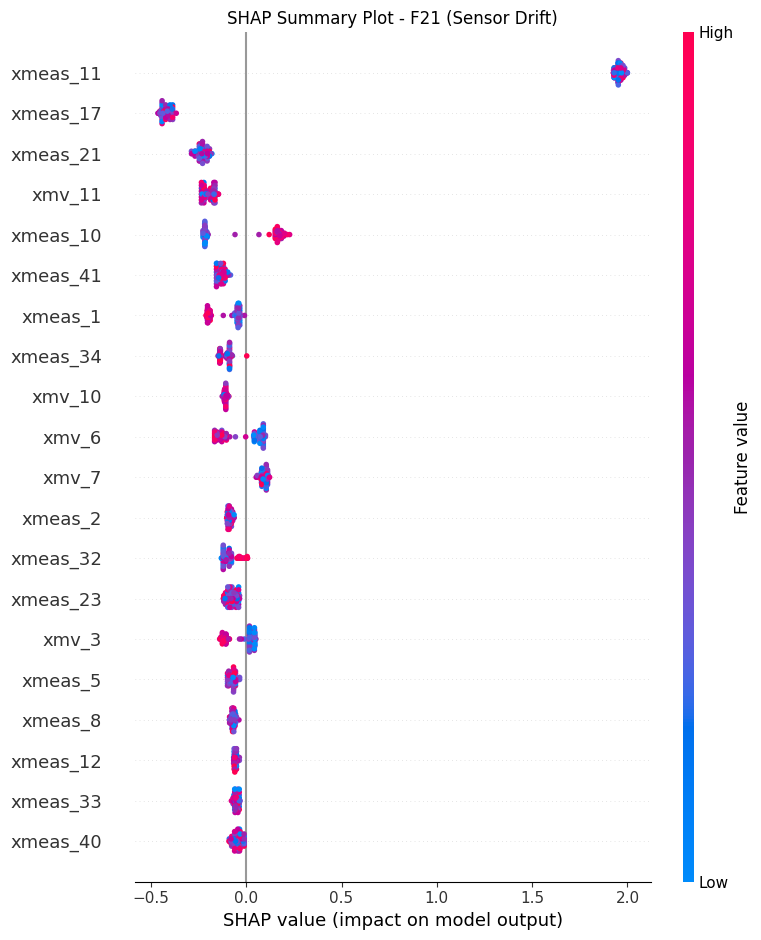

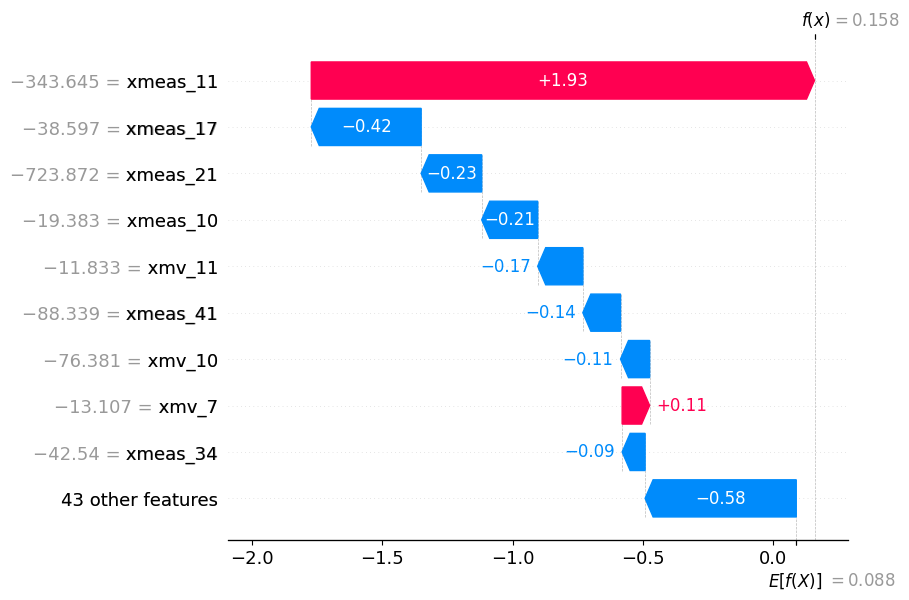

<Figure size 640x480 with 0 Axes>

🔄 معالجة F0 (الحالة الطبيعية)...


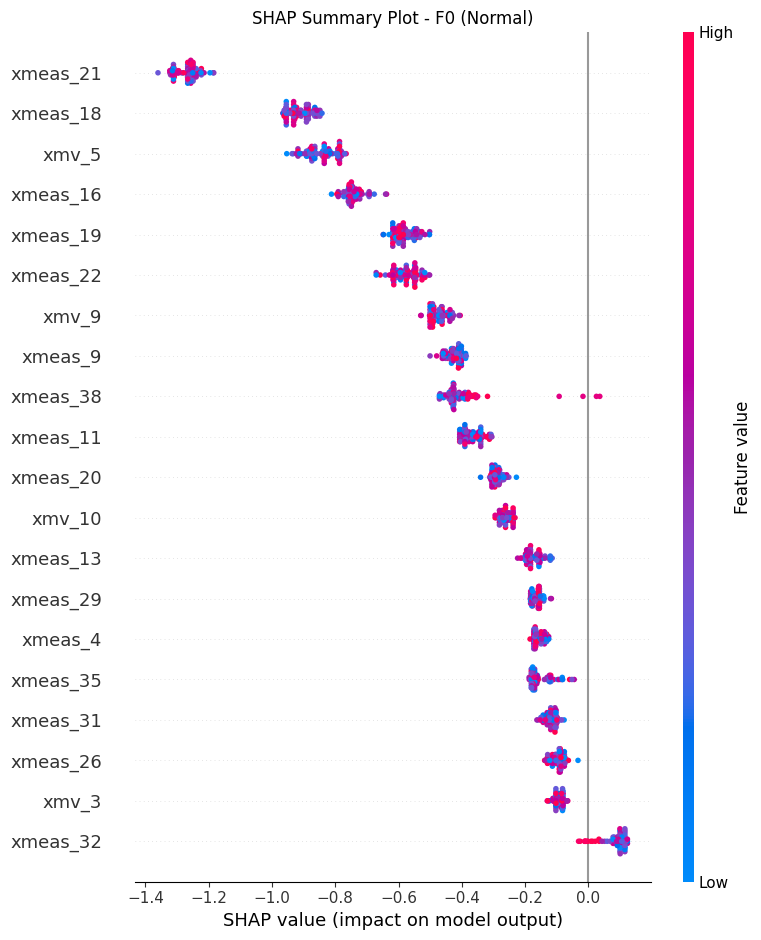


📊 أهم 10 مستشعرات في F21:
 Feature  SHAP_F0  SHAP_F21
xmeas_11 0.367232  1.957976
xmeas_17 0.071346  0.419376
xmeas_21 1.270388  0.230954
  xmv_11 0.019911  0.196351
xmeas_10 0.042287  0.192771
xmeas_41 0.032132  0.128614
 xmeas_1 0.033939  0.114371
xmeas_34 0.025119  0.112577
  xmv_10 0.259474  0.108746
   xmv_6 0.011692  0.100606

✅ تم الحفظ بنجاح!


In [ ]:
# ==============================
# XAI: SHAP على XGBoost (F0 و F21) - نسخة متوافقة 100%
# ==============================

import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# دالة موحدة للحصول على SHAP values (تعمل مع جميع الإصدارات)
def get_shap_values_for_class(explainer, X, class_label, label_classes):
    shap_values = explainer(X)
    class_index = np.where(label_classes == class_label)[0][0]
    return shap_values[:, :, class_index].values  # (n_samples, n_features)

# 1. === SHAP على F21 ===
print("🔄 معالجة F21 (Sensor Drift)...")
f21_samples = test_df[test_df['faultNumber'] == 21].sample(n=100, random_state=42)
X_f21 = f21_samples[SENSOR_COLUMNS].values
X_f21_scaled = scaler.transform(X_f21)

# استخدام Explainer جديد (يدعم الإصدارات الحديثة)
explainer = shap.Explainer(xgb_model)

# الحصول على قيم SHAP للفئة F21
shap_f21 = get_shap_values_for_class(explainer, X_f21_scaled, 21, label_classes)

# Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_f21, X_f21_scaled, feature_names=SENSOR_COLUMNS, show=False)
plt.title("SHAP Summary Plot - F21 (Sensor Drift)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TEP_Data/shap_summary_f21.png", dpi=150)
plt.show()

# Waterfall
plt.figure()
shap.waterfall_plot(shap.Explanation(
    values=shap_f21[0],
    base_values=explainer.expected_value[0],  # المتوسط العام
    data=X_f21_scaled[0],
    feature_names=SENSOR_COLUMNS
))
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TEP_Data/shap_waterfall_f21_sample.png", dpi=150)
plt.show()

# 2. === SHAP على F0 ===
print("🔄 معالجة F0 (الحالة الطبيعية)...")
f0_samples = test_df[test_df['faultNumber'] == 0].sample(n=100, random_state=42)
X_f0 = f0_samples[SENSOR_COLUMNS].values
X_f0_scaled = scaler.transform(X_f0)

shap_f0 = get_shap_values_for_class(explainer, X_f0_scaled, 0, label_classes)

plt.figure(figsize=(10, 8))
shap.summary_plot(shap_f0, X_f0_scaled, feature_names=SENSOR_COLUMNS, show=False)
plt.title("SHAP Summary Plot - F0 (Normal)")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/TEP_Data/shap_summary_f0.png", dpi=150)
plt.show()

# 3. === المقارنة ===
mean_shap_f0 = np.mean(np.abs(shap_f0), axis=0)
mean_shap_f21 = np.mean(np.abs(shap_f21), axis=0)

comparison_df = pd.DataFrame({
    'Feature': SENSOR_COLUMNS,
    'SHAP_F0': mean_shap_f0,
    'SHAP_F21': mean_shap_f21
}).sort_values('SHAP_F21', ascending=False)

print("\n📊 أهم 10 مستشعرات في F21:")
print(comparison_df.head(10).to_string(index=False))
comparison_df.to_csv("/content/drive/MyDrive/TEP_Data/shap_comparison_f0_f21.csv", index=False)

print("\n✅ تم الحفظ بنجاح!")